In [2]:
import yfinance 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-19 19:58:53.510270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
ticker = 'AAPL'
df = yfinance.download(ticker)
open_values = df.iloc[:, 0:1].values
len(open_values)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600
...,...,...,...,...,...,...
2024-05-13,185.440002,187.100006,184.619995,186.279999,186.279999,72044800
2024-05-14,187.509995,188.300003,186.289993,187.429993,187.429993,52393600
2024-05-15,187.910004,190.649994,187.369995,189.720001,189.720001,70400000


In [4]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0,1))
open_values = mms.fit_transform(open_values)
open_values

array([[3.97448390e-04],
       [3.66443799e-04],
       [3.21341048e-04],
       ...,
       [9.48931741e-01],
       [9.61862958e-01],
       [9.57013713e-01]])

Take the previous 100 timesteps into one array and make X_train and y_train based off such values.

In [5]:
X_train = []
y_train = []
marker = int(.8 * len(open_values))
for i in range(100, marker):
  X_train.append(open_values[i-100:i, 0])
  y_train.append(open_values[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# change it to a 3D tensor

X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
X_train.shape

(8659, 100, 1)

In [6]:
class LSTM():
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
    self.model = None
  
  def check(self):
    return self.model.summary
  
  def create_model(self):
    model = tf.keras.models.Sequential(
      layers=[
        tf.keras.layers.Input(shape=(self.x_train.shape[1], 1)),
        tf.keras.layers.LSTM(units=60, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.LSTM(units=60, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.LSTM(units=60, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.LSTM(units=60),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(units=1)
      ] 
    )

    self.model = model
  
  def compile(self):
    self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=[])
    return self.model.fit(self.x_train, self.y_train, epochs=3, batch_size=500)
  
  def predict(self, x_test):
    return self.model.predict(x_test)
    

In [7]:
model = LSTM(X_train, y_train)
model.create_model()
model.compile()

2024-05-19 19:58:57.872909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
18/18 [==============================] - 12s 457ms/step - loss: 4.6111e-04
Epoch 2/3
18/18 [==============================] - 9s 483ms/step - loss: 6.4213e-05
Epoch 3/3
18/18 [==============================] - 7s 410ms/step - loss: 2.7317e-05


create testing dataset

In [8]:
X_test = []
y_truth = []

dataset_total = df['Open']
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
inputs = mms.transform(inputs)

for i in range(marker, len(dataset_total)):
  X_test.append(inputs[i-100:i, 0])
  y_truth.append(inputs[i, 0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_truth = np.array(y_truth).reshape(-1, 1) 
predicted_stock_price = model.predict(X_test)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)
y_truth = mms.inverse_transform(y_truth)
  

69/69 [==============================] - 3s 31ms/step


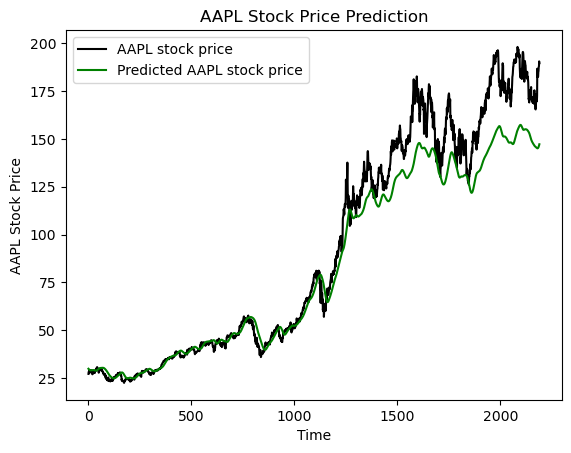

AAPL_stock_plot_lstm.png


In [9]:
import os

plt.plot(y_truth, color = 'black', label = f'{ticker} stock price')
plt.plot(predicted_stock_price, color = 'green', label = f'Predicted {ticker} stock price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} Stock Price')
plt.legend()

image_path = os.path.join(f'{ticker}_stock_plot_lstm.png')

plt.savefig(image_path)
plt.show()
plt.close()
print(image_path)


In [10]:
from sklearn.metrics import r2_score
r2 = r2_score(y_truth, predicted_stock_price)
print(r2)

0.9291493365160046
